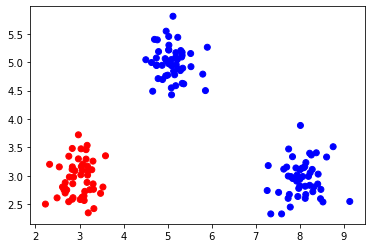

(150,)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import linalg
from scipy import stats

N1 = 50
N2 = 50
N3 = 50
K = 2
sigma = 0.1

mean = (3, 3)
cov = [[sigma, 0], [0, sigma]]
X1 = np.random.multivariate_normal(mean, cov, N1)
c1 = ['red'] *len(X1)

mean = (5, 5)
cov = [[sigma, 0], [0, sigma]]
X2 = np.random.multivariate_normal(mean, cov, N2)
c2 = ['blue'] *len(X2)

mean = (8, 3)
cov = [[sigma, 0], [0, sigma]]
X3 = np.random.multivariate_normal(mean, cov, N3)
c3 = ['blue'] *len(X3)

X = np.concatenate((X1, X2, X3))
color = np.concatenate((c1, c2,c3))

# ground truth of classification
T = np.zeros([len(X), K])
for n in range(len(X)):
    if(n<N1):
        T[n][0] = 1
    elif(n<N1+N2+N3):
        T[n][1] = 1
T = T.astype(int)
        

plt.scatter(X[:, 0], X[:, 1], marker='o', c = color)
plt.show()
np.shape(T[:,1])


In [2]:

def sigmoid(x):
    s = 1 / (1 + np.exp(-x))
    return s

def basis_function_gaussian(X, M, sigma):
    mu_m = np.arange(0, 10, 10/M)
    N = len(X)
    Fi = np.zeros([N, M])
#     distance_s = np.zeros([shape(X)])
    for i in range(M):
        distance_s = (X[:, 0] - mu_m[i])**2 + (X[:, 1] - mu_m[i])**2
        Fi[:, i] = np.exp(-0.5 * distance_s/sigma**2)
    return Fi
# N*M
# Fi = basis_function_gaussian(X, 3, 1)

In [140]:
def Map_classification(X, T, M, sigma):
    N = len(X)
    alpha = 1
    
    # Init W
    W_old = np.zeros([M, 1])
    delta = np.ones([M, 1])   
    sig = np.zeros([N, 1])
    R = np.zeros([N, N])
    y = np.zeros([N, 1])
    times = 0
    
    # N*1
    t = T[:,1].reshape(N, 1)
    
    # N*M
    Fi = basis_function_gaussian(X, M, sigma)
    # M*M
    S0 = 1/alpha * np.eye(M, M)
    
    while np.abs(np.max(delta)) > 10e-09:
        # W.T X FI = 1*M X M*N
        # sig = N*1
        sig = sigmoid(np.dot(Fi, W_old))
        y = sig[:, 0]
        R = np.diag(y * (1 - y))
        y = y.reshape(N, 1)
        
        # E = M*M(M*1) + M*N(N*1 - N*1) = M*1
        grad_E = np.dot(S0, W_old) + np.dot(Fi.T, (y - t))
        # H = M*N X N*N X N*M + M*M
        H = np.dot(np.dot(Fi.T, R), Fi) + S0
#         print(np.shape(H))
#         print(np.shape(grad_E))
    
        # W = M*1
        W_new = W_old - np.dot(np.linalg.inv(H), grad_E)
#         print(np.shape(W_new))
        delta = W_new - W_old
        W_old = W_new
        times += 1
    
    y = sigmoid(np.dot(Fi, W_old))

    print("Error of W is:\n", delta)

    print("Convergence after %d times iteration" %(times))
       
    return W_old, y

W_MAP, Y = Map_classification(X, T, 5, 4)   

Error of W is:
 [[-3.77875509e-12]
 [-3.35509398e-12]
 [ 1.83569306e-12]
 [ 6.69020395e-12]
 [ 6.07558448e-12]]
Convergence after 6 times iteration


Text(0.5, 1.0, 'Test for classification on scatter')

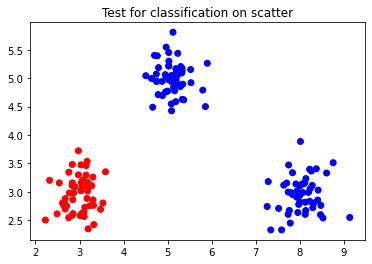

In [141]:
color_p = []
for i in range(150):
    color_p.append('red' if Y[i]<0.5 else 'blue')
plt.scatter(X[:, 0], X[:, 1], c=color_p)
plt.title("Test for classification on scatter")

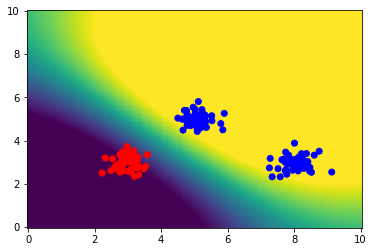

In [142]:
# probability map

def Predictive_classification(X, M, sigma):
    alpha = 0.3
    
    # Fi = 1*M
    Fi = basis_function_gaussian(X, M, sigma)
    
    # sig = 1*1
    sig = sigmoid(np.dot(Fi, W_MAP))
    y = sig[:, 0]
    R = np.diag(y * (1 - y))
        
    S0 = 1/alpha * np.eye(M, M)
    # Sn = H; H = M*N X N*N X N*M + M*M
    Sn = np.dot(np.dot(Fi.T, R), Fi) + S0
    Sn = np.linalg.inv(Sn)
    
    SIGMA = np.dot(np.dot(Fi, Sn), Fi.T)
#     W_MAP, Y = Map_classification(X, T, 10, 1)    
    a_map = np.dot(Fi, W_MAP)
    C = sigmoid(a_map)
    p = sigmoid(a_map/np.sqrt((1 + np.pi/8 * SIGMA)))
    return C, p, SIGMA

tx = np.linspace(0, 10, 150)
ty = np.linspace(0, 10, 150)
tp = np.zeros([150, 150])
for i in range(150):
    for j in range(150):
        inputx = np.array([[tx[i], ty[j]]])
        C, P, S = Predictive_classification(inputx, 5, 4)
        tp[i][j] = (P-0.5)*800

xx, yy = np.meshgrid(tx, ty)

tp_min, tp_max = -np.abs(tp).max(), np.abs(tp).max() 
plt.pcolormesh(xx, yy, tp, vmin=-255, vmax=255)
plt.scatter(X[:, 0], X[:, 1], c=color_p)    

In [ ]:
# Input new point for classification
while True:    
    input_point = input('Input new point(x y): ')
    new_point = [float(n) for n in input_point.split()]

    inputx = np.array([new_point])
    C, P, S = Predictive_classification(inputx, 5, 4)

    if P>0.5:
        classification = 'C2'
    else:
        classification = 'C1'
    print("This point belongs to: ", classification)
    print("The uncertainty information is: ", S)

Input new point(x y): 5 5
This point belongs to:  C2
The uncertainty information is:  [[0.69793385]]
Input new point(x y): 7 8
This point belongs to:  C2
The uncertainty information is:  [[0.56891154]]
Input new point(x y): 5 4
This point belongs to:  C2
The uncertainty information is:  [[0.64465315]]
